# Object Detection and Image Classifier for Airlines

![Demo](https://raw.githubusercontent.com/joaobi/planespotter/master/images/readme4.jpg)


### Use Cases
1. Object Detection - detect the planes in a given image and draw bounding boxes around them
2. Object Classification - detect the airlines for each plane

### Flow
1. Detect the planes: get the bounding boxes
2. Crop each plane (bounding Box) and classify its airline
3. Draw the Bounding Boxes and classes on the original image



### Technology:
* Tensorflow Object Detection API - The object (plane) detection API used. Used the standard MSCOCO image library
* Custom airline classifier model built on Keras using the Tensorflow backend - included in code (images not included)



### Classifier mode currently supports:
* Emirates
* Singapore Airlines
* ANA
* Asiana
* Korean Airlines
* Qantas

In [1]:
!wget  https://saplanespotter.blob.core.windows.net/saplanespotterpub/libs.zip
!unzip libs.zip
!wget https://saplanespotter.blob.core.windows.net/saplanespotterpub/models.zip
!unzip models.zip

!wget https://saplanespotter.blob.core.windows.net/saplanespotterpub/images.zip
!unzip images.zip

--2018-11-23 18:25:54--  https://saplanespotter.blob.core.windows.net/saplanespotterpub/libs.zip
Resolving webproxy (webproxy)... 10.36.39.1
Connecting to webproxy (webproxy)|10.36.39.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 275395 (269K) [application/x-zip-compressed]
Saving to: ‘libs.zip.1’

libs.zip.1          100%[===================>] 268.94K   363KB/s    in 0.7s    

2018-11-23 18:25:58 (363 KB/s) - ‘libs.zip.1’ saved [275395/275395]

Archive:  libs.zip
replace libs/object_detection/core/__init__.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
--2018-11-23 18:26:16--  https://saplanespotter.blob.core.windows.net/saplanespotterpub/models.zip
Resolving webproxy (webproxy)... 10.36.39.1
Connecting to webproxy (webproxy)|10.36.39.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 139078902 (133M) [application/x-zip-compressed]
Saving to: ‘models.zip.1’

models.zip.1        100%[===================>] 132.64M  1.04MB/s    in 

In [237]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import numpy as np
import time
from PIL import ImageDraw
import PIL.ImageFont as ImageFont
from PIL import Image, ExifTags
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.models import load_model

sys.path.append(os.path.abspath('libs'))

SIZE = 1024 # Resize for better inference

BB_COLOR = 'LimeGreen'
BB_TEXT_COLOR = 'Black'

photo_size = 200 # Size for loading into CNN
PLANE_DETECTION_THRESHOLD = 0.60 # Detect plans above this prob. threshold

PATH_TO_FROZEN_GRAPH = 'frozen_inference_graph.pb'
predict_model_name = '6airlines_75epochs_200_3.h5'
model_location = 'models'

airline_names = {0: 'Emirates', 1: 'Korean Air', 2: 'ANA', 3: 'Asiana', 4:'Qantas', 5:'Singapore Airlines'}

In [242]:
def preprocess_image(image_name,resize = True,size = SIZE):
    img=Image.open(image_name)

    if img.format=='JPEG':
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation]=='Orientation':
                break
        # Rotate the image if needed
        if img._getexif() != None:
            exif=dict(img._getexif().items())
            if orientation in exif.keys():
                if exif[orientation] == 3:
                    img=img.rotate(180, expand=True)

    # resize to get better inference speeds
    if resize:
        basewidth = size
        wpercent = (basewidth / float(img.size[0]))
        hsize = int((float(img.size[1]) * float(wpercent)))
        img = img.resize((basewidth, hsize), Image.ANTIALIAS)

    (im_width, im_height) = img.size
    if img.format == 'PNG':
        image = img.convert('RGB')
    image_np =  np.array(img.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)     

    return img,image_np

def build_obj_detection_graph(model_name):
    # global detection_graph
    detection_graph = tf.Graph()

    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(model_name, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph

def run_inference_for_single_image(image,session):
    step_time = time.time()
    # global detection_graph
    with detection_graph.as_default():
      sess = session
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})
      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
        
    print("[Detection     ] --- %.2f seconds ---" % (time.time() - step_time))

    return output_dict

def draw_custom_bounding_boxes(model,image,image_np,output_dict):
    thickness = 4    
    step_time = time.time()

    try:
        font = ImageFont.truetype('FreeSerif.ttf', 24)
    except IOError:
        font = ImageFont.load_default()        

    final_image = Image.fromarray(image_np)

    draw = ImageDraw.Draw(final_image)
    im_width, im_height = final_image.size
    
    plane_idxs = np.where(output_dict['detection_classes']==5)
    num_planes_image = len(output_dict['detection_boxes'][plane_idxs])

    for i in range(0,num_planes_image):
        plane_acc_score = output_dict['detection_scores'][plane_idxs][i]
        if (plane_acc_score>PLANE_DETECTION_THRESHOLD):
            ymin = output_dict['detection_boxes'][plane_idxs][i][0]
            xmin = output_dict['detection_boxes'][plane_idxs][i][1]
            ymax = output_dict['detection_boxes'][plane_idxs][i][2]
            xmax = output_dict['detection_boxes'][plane_idxs][i][3]

            # Crop the plane and predict it's class (airline)
            area = (xmin * im_width, 
                  ymin * im_height,
                  xmax * im_width,
                  ymax * im_height)

            image2 = preprocess_image(image_name)       
            photo2 = image.crop(area)
            photo2 = photo2.resize((photo_size,photo_size), Image.ANTIALIAS)    
            
            x = np.array(photo2)
            x = x / 255.  
            x = np.expand_dims(x, axis=0)

            preds = model.predict(x)

            predicted_airline = airline_names[np.argmax(preds[0])]
            prob = np.max(preds[0])*100
            
            # Print the cropped plan and its class
#             plt.title('Airline '+predicted_airline+' with acc. '+ str(prob))
#             plt.imshow(photo)
#             plt.axis('off')
#             plt.show()
            
            # Draw the bounding Boxes around the plane and the label
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom),
                 (right, top), (left, top)], width=thickness, fill=BB_COLOR)

            text_bottom = top

            display_str = '%s (%.2f%%)'%(predicted_airline,prob)

            text_width, text_height = font.getsize(display_str)
            margin = np.ceil(0.05 * text_height)

            draw.rectangle(
                    [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
                fill=BB_COLOR)
            draw.text(
                    (left + margin, text_bottom - text_height - margin),
                    display_str,
                    fill=BB_TEXT_COLOR,
                    font=font)
            text_bottom -= text_height - 2 * margin

    (im_width, im_height) = final_image.size
    if final_image.format == 'PNG':
        final_image = final_image.convert('RGB')


    image_np =  np.array(final_image.getdata()).reshape(
            (im_height, im_width, 3)).astype(np.uint8)
    
    print("[Classification] --- %.2f seconds ---" % (time.time() - step_time))
    
    return image_np

In [5]:
classifier_model_location = os.path.join(model_location,predict_model_name)

model = load_model(classifier_model_location)
model.load_weights(classifier_model_location)
model._make_predict_function()

detection_model_location = os.path.join(model_location,PATH_TO_FROZEN_GRAPH)
detection_graph = build_obj_detection_graph(detection_model_location)

session = tf.Session(graph=detection_graph)

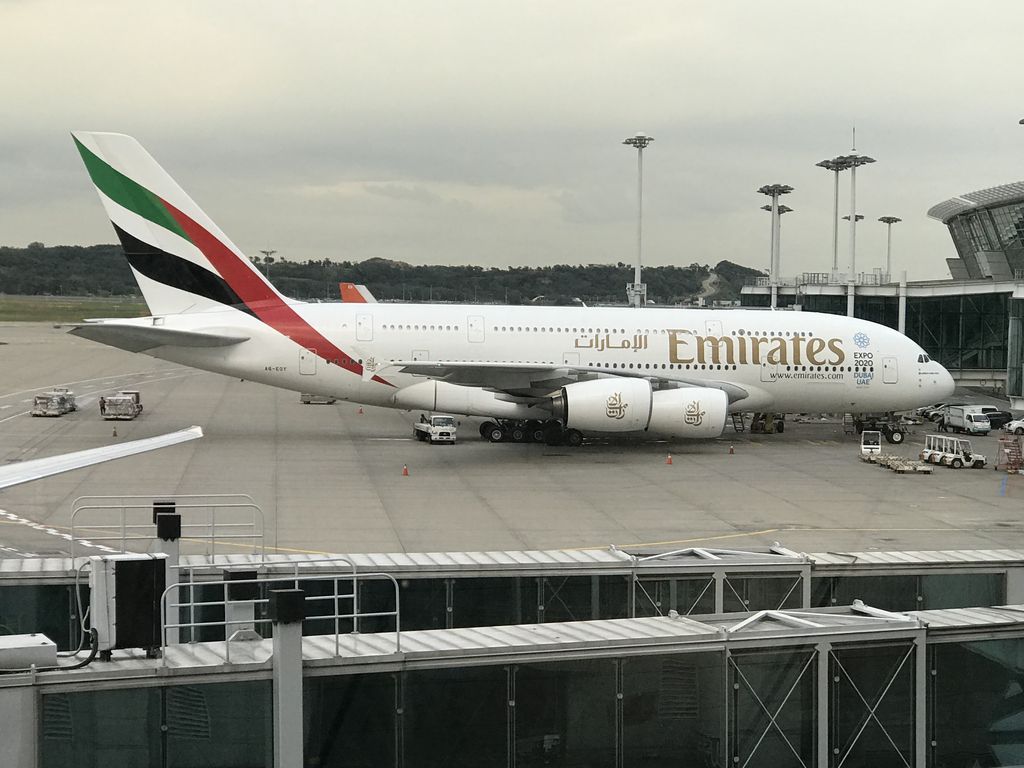

In [243]:
# Load Image
image_name = "uploads/1_EK.jpg"
image,image_np = preprocess_image(image_name)
image

In [244]:
# Plane detection
output_dict = run_inference_for_single_image(image_np,session)

# Airline Classification (per plane)
new_np = draw_custom_bounding_boxes(model,image,image_np,output_dict)

[Detection     ] --- 0.81 seconds ---
[Classification] --- 14.48 seconds ---


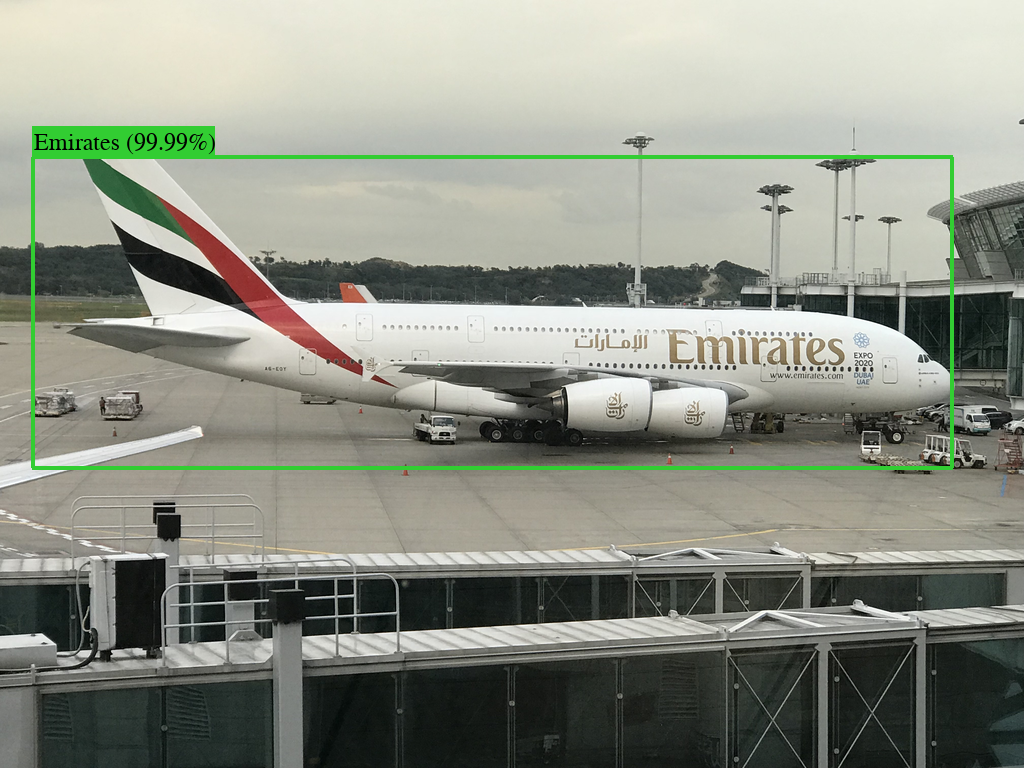

In [245]:
img = Image.fromarray(new_np)
img

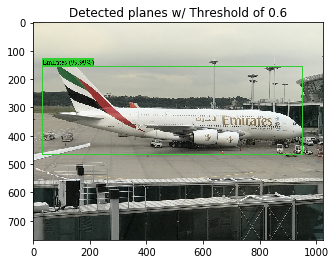

In [235]:
plt.figure()
plt.title('Detected planes w/ Threshold of %s'%(PLANE_DETECTION_THRESHOLD))
plt.imshow(Image.fromarray(new_np))
plt.axis('on')
plt.show()